# Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import torch 
import torch.nn.functional as F 

from tqdm.notebook import tqdm
import utils

# Load MNIST Handwritten Dataset

In [2]:
from torchvision import datasets 
from torchvision import transforms as T

In [3]:
train_augs = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.ToTensor(),
    T.Normalize(mean=0.5, std=0.5)
])

valid_augs = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=0.5, std=0.5)
])

In [4]:
trainset = datasets.MNIST('./', download = False, train = True, transform = train_augs)
testset = datasets.MNIST('./', download = False, train = False, transform = valid_augs)

In [5]:
trainset, validset = torch.utils.data.random_split(trainset, [50000,10000])

In [6]:
print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validset)}")
print(f"Size of testset : {len(testset)}")

Size of trainset : 50000
Size of validset : 10000
Size of testset : 10000


shape of image : torch.Size([1, 28, 28])
For visualization we need (h x w x c) so using permute shape will be : torch.Size([28, 28, 1])


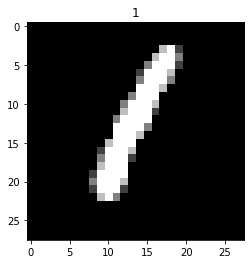

In [7]:
idx = 1
image, label = trainset[idx]

print(f'shape of image : {image.shape}')

print(f'For visualization we need (h x w x c) so using permute shape will be : {image.permute(1, 2, 0).shape}')

plt.imshow(image.permute(1, 2, 0), cmap = 'gray')
plt.title(label);

# Load Dataset into batches

In [8]:
from torch.utils.data import DataLoader

In [9]:
bs = 64
trainloader = DataLoader(trainset,batch_size = bs, shuffle = True)
validloader = DataLoader(validset,batch_size = bs)
testloader = DataLoader(testset,batch_size = bs)

In [10]:
print(f'Total no. of batches in trainloader : {len(trainloader)}')
print(f'Total no. of batches in validloader : {len(validloader)}')
print(f'Total no. of batches in testloader : {len(testloader)}')

Total no. of batches in trainloader : 782
Total no. of batches in validloader : 157
Total no. of batches in testloader : 157


In [11]:
for images, labels in trainloader:
    print(f'One image batch shape : {images.shape}')
    print(f'One image labels shape : {labels.shape}')
    break;
    

One image batch shape : torch.Size([64, 1, 28, 28])
One image labels shape : torch.Size([64])


# Load Model 

In [12]:
from models import DigitModel

model = DigitModel()
model.to('cpu')

DigitModel(
  (cnn_block): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_featu

# Create Train and Eval Function

In [13]:
def train_fn(model, dataloader, criterion, optimizer):
    model.train()
    total_loss =0.0
    total_acc=0.0
    
    for images, labels in tqdm(dataloader):
        
        images = images.to('cpu')
        labels = labels.to('cpu')
        
        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()        
        total_acc += utils.multiclass_accuracy(logits, labels)
        
    return total_loss / len(dataloader), total_acc / len(dataloader)    
        

In [14]:
def eval_fn(model, dataloader, criterion):
    
    model.eval()
    total_loss =0.0
    total_acc=0.0
    
    with torch.no_grad():
        
        for images, labels in tqdm(dataloader):
            
            images = images.to('cpu')
            labels = labels.to('cpu')
        
            logits = model(images)
            loss = criterion(logits, labels)
        
            total_loss += loss.item()        
            total_acc += utils.multiclass_accuracy(logits, labels)
        
        return total_loss / len(dataloader), total_acc / len(dataloader)    
        

# Training Loop 

In [15]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.003)

In [16]:
best_valid_loss = np.Inf

for i in range(7):
    
    train_loss, train_acc = train_fn(model, trainloader, criterion, optimizer)
    valid_loss, valid_acc = eval_fn(model, trainloader, criterion)
    
    print(f"Epoch {i+1} Train Loss : {train_loss} Train Acc : {train_acc}")
    print(f"Epoch {i+1} Valid Loss : {valid_loss} Valid Acc : {valid_acc}")
          
    if valid_loss < best_valid_loss:
          torch.save(model.state_dict(), 'best_weights.pt')
          print('SAVED BEST MODEL')
          best_valid_loss = valid_loss
          

  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1 Train Loss : 0.7355803217538788 Train Acc : 0.7496004104614258
Epoch 1 Valid Loss : 0.2369700462731254 Valid Acc : 0.9307065010070801
SAVED BEST MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2 Train Loss : 0.37504567488875534 Train Acc : 0.8852701187133789
Epoch 2 Valid Loss : 0.1849756336978177 Valid Acc : 0.9468910098075867
SAVED BEST MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3 Train Loss : 0.2940767643939885 Train Acc : 0.9103260636329651
Epoch 3 Valid Loss : 0.14974048952131397 Valid Acc : 0.9563818573951721
SAVED BEST MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4 Train Loss : 0.2576599195409004 Train Acc : 0.9221746921539307
Epoch 4 Valid Loss : 0.13674413035516544 Valid Acc : 0.9581401944160461
SAVED BEST MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5 Train Loss : 0.23564462259869137 Train Acc : 0.9286684989929199
Epoch 5 Valid Loss : 0.12621127600874513 Valid Acc : 0.9621962904930115
SAVED BEST MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6 Train Loss : 0.2165826725775895 Train Acc : 0.9366608262062073
Epoch 6 Valid Loss : 0.11598136129162614 Valid Acc : 0.9641743898391724
SAVED BEST MODEL


  0%|          | 0/782 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7 Train Loss : 0.20898178218366087 Train Acc : 0.9386588931083679
Epoch 7 Valid Loss : 0.10124377158763426 Valid Acc : 0.9703285098075867
SAVED BEST MODEL


# Inference

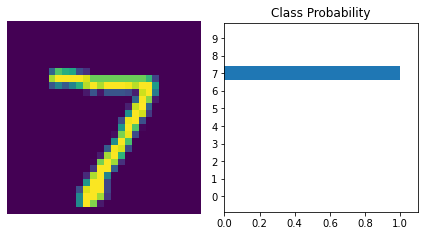

In [17]:
image, label = testset[0]

weights = torch.load('best_weights.pt')
model.load_state_dict(weights)

model.eval()
with torch.no_grad():
    logits=model(image.unsqueeze(0))
    ps = torch.nn.Softmax(dim = 1)(logits)[0]
    utils.view_classify(image, ps)